In [4]:
pip install cucim


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cucim (from versions: none)
ERROR: No matching distribution found for cucim


Processing timepoints: 100%|████████████████████████████████████████████████████████| 74/74 [02:17<00:00,  1.86s/frame]


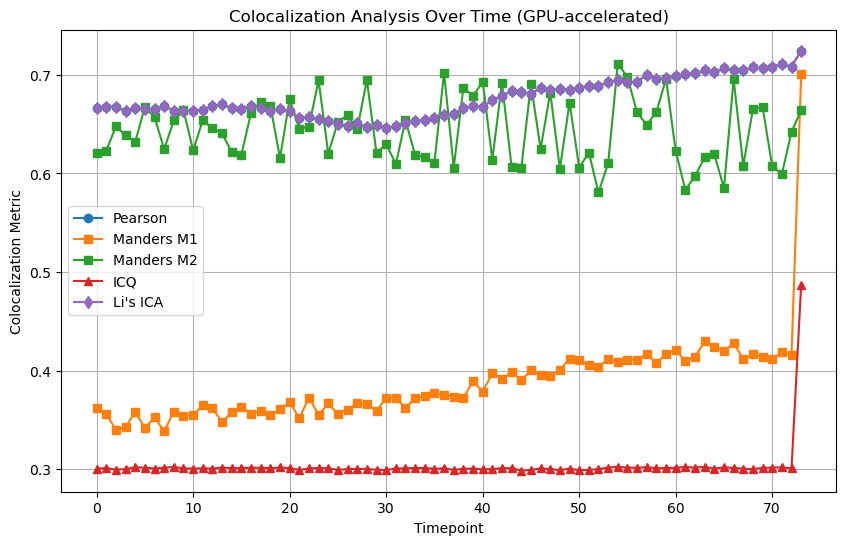

In [6]:
import cupy as cp
import tifffile
import matplotlib.pyplot as plt
from skimage import filters
from scipy.stats import pearsonr
from tqdm import tqdm  # Progress bar

# Load a 5D TIFF file (T, Z, C, Y, X) using tifffile and convert to CuPy
def load_5d_tiff(file_path):
    img = tifffile.imread(file_path)  # Load with tifffile
    return cp.asarray(img)  # Convert to CuPy for GPU processing

# Preprocess: Gaussian filter + normalize using CuPy
def preprocess_image(img, sigma=1):
    filtered = filters.gaussian(cp.asnumpy(img), sigma=sigma)  # Filter on CPU
    return cp.asarray((filtered - filtered.min()) / (filtered.max() - filtered.min()))  # Return to GPU

# Pearson's Correlation (using CPU for calculation)
def compute_pearson_coefficient(ch1, ch2):
    ch1_cpu, ch2_cpu = cp.asnumpy(ch1.flatten()), cp.asnumpy(ch2.flatten())  # Transfer to CPU
    return pearsonr(ch1_cpu, ch2_cpu)[0]

# Manders' Coefficients (GPU)
def compute_manders_coefficients(ch1, ch2, threshold_ch1=None, threshold_ch2=None):
    if threshold_ch1 is None:
        threshold_ch1 = filters.threshold_otsu(cp.asnumpy(ch1))  # Compute threshold on CPU
    if threshold_ch2 is None:
        threshold_ch2 = filters.threshold_otsu(cp.asnumpy(ch2))

    mask_ch1 = ch1 > threshold_ch1
    mask_ch2 = ch2 > threshold_ch2

    M1 = cp.sum(ch1[mask_ch2]) / cp.sum(ch1) if cp.sum(ch1) != 0 else 0
    M2 = cp.sum(ch2[mask_ch1]) / cp.sum(ch2) if cp.sum(ch2) != 0 else 0

    return float(M1), float(M2)  # Convert to Python floats

# Intensity Correlation Quotient (ICQ) using CuPy
def compute_icq(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    product = (ch1 - mean_ch1) * (ch2 - mean_ch2)
    icq = cp.sum(product > 0) / product.size - 0.5
    return float(icq)

# Li's ICA using CuPy
def compute_lis_ica(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    numerator = cp.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
    denominator = cp.sqrt(cp.sum((ch1 - mean_ch1) ** 2) * cp.sum((ch2 - mean_ch2) ** 2))
    return float(numerator / denominator) if denominator != 0 else 0

# Process the 5D stack and compute metrics over time (GPU)
def process_colocalization(file_path):
    img = load_5d_tiff(file_path)
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    # Store colocalization metrics over time
    pearson_vals, manders_M1, manders_M2, icq_vals, lis_ica_vals = [], [], [], [], []

    # Add tqdm progress bar for timepoints
    for t in tqdm(range(T), desc="Processing timepoints", unit="frame"):
        ch1 = preprocess_image(img[t, :, 0, :, :])  # Channel 1 (GPU)
        ch2 = preprocess_image(img[t, :, 1, :, :])  # Channel 2 (GPU)

        pearson_vals.append(compute_pearson_coefficient(ch1, ch2))
        M1, M2 = compute_manders_coefficients(ch1, ch2)
        manders_M1.append(M1)
        manders_M2.append(M2)
        icq_vals.append(compute_icq(ch1, ch2))
        lis_ica_vals.append(compute_lis_ica(ch1, ch2))

    # Plot colocalization metrics over time
    timepoints = cp.asnumpy(cp.arange(T))  # Convert to NumPy for plotting

    plt.figure(figsize=(10, 6))
    plt.plot(timepoints, pearson_vals, label="Pearson", marker="o")
    plt.plot(timepoints, manders_M1, label="Manders M1", marker="s")
    plt.plot(timepoints, manders_M2, label="Manders M2", marker="s")
    plt.plot(timepoints, icq_vals, label="ICQ", marker="^")
    plt.plot(timepoints, lis_ica_vals, label="Li's ICA", marker="d")

    plt.xlabel("Timepoint")
    plt.ylabel("Colocalization Metric")
    plt.title("Colocalization Analysis Over Time (GPU-accelerated)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the analysis
file_path = r"Z:\Shared299\KinetochoreClub\for Nina\03 PhD lattice movies\20241023 NP_002 MC256 2-colour 4-sec NEBD\Decon 10 iterations\Cell018_Slide 5 capture 3_DC_DS.tif"
process_colocalization(file_path)


Sigma 3: Processing timepoints: 100%|███████████████████████████████████████████████| 74/74 [02:38<00:00,  2.15s/frame]


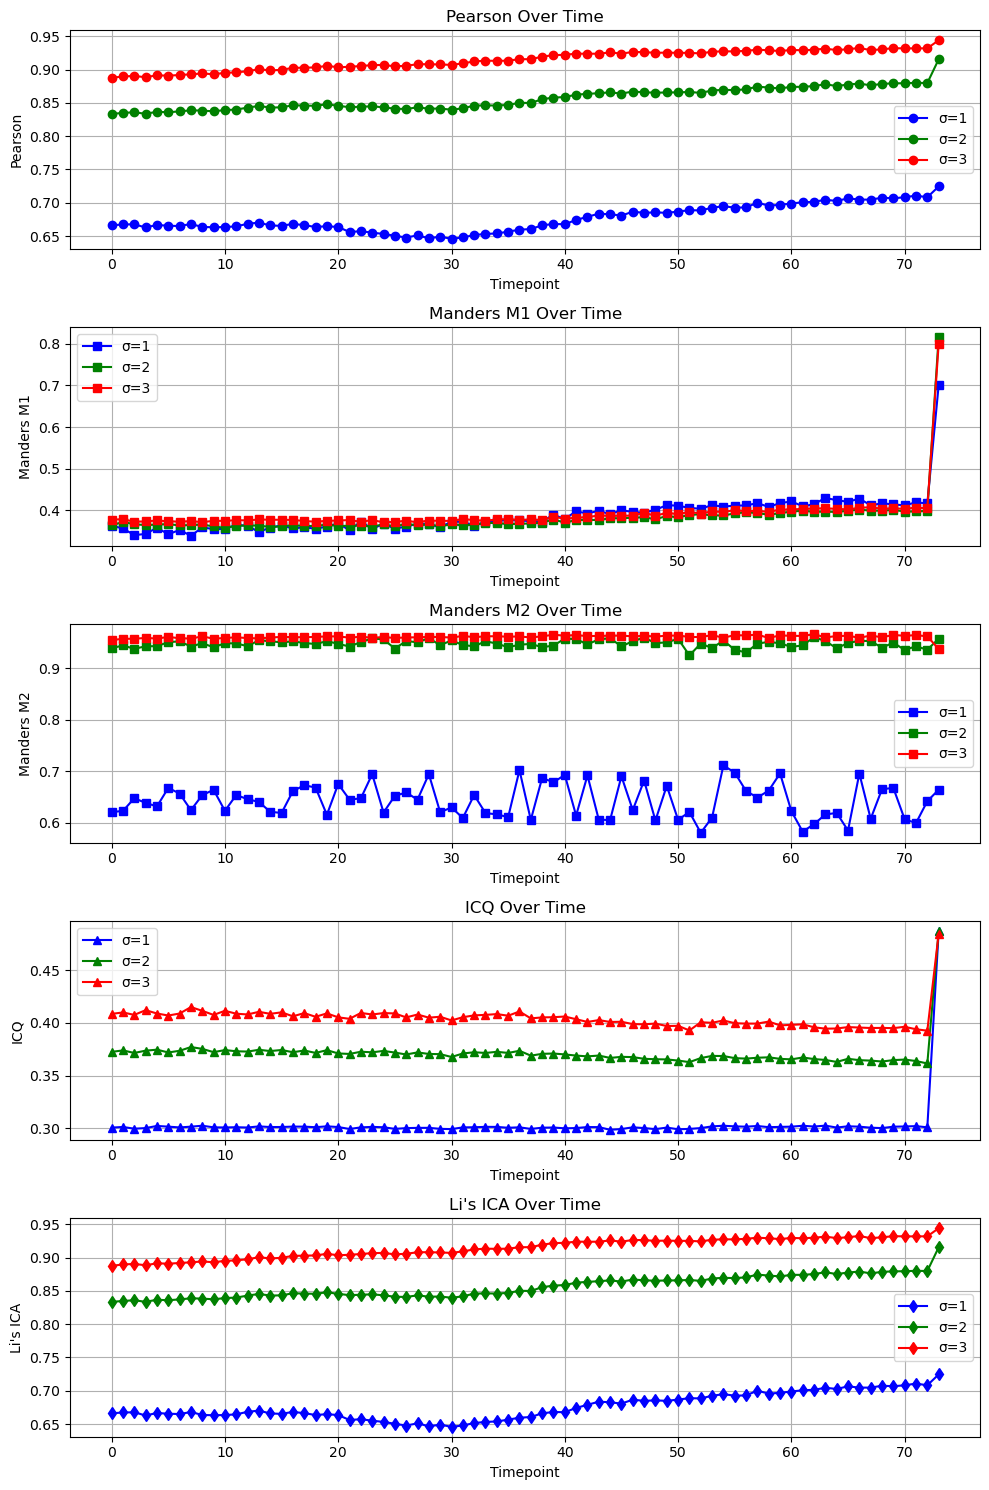

In [18]:
import cupy as cp
import tifffile
import matplotlib.pyplot as plt
from skimage import filters
from scipy.stats import pearsonr
from tqdm import tqdm  # Progress bar

# Load a 5D TIFF file (T, Z, C, Y, X)
def load_5d_tiff(file_path):
    img = tifffile.imread(file_path)  # Load with tifffile
    return cp.asarray(img)  # Convert to CuPy for GPU processing

# Preprocess: Gaussian filter + normalize using CuPy
def preprocess_image(img, sigma=1):
    filtered = filters.gaussian(cp.asnumpy(img), sigma=sigma)  # Apply Gaussian filtering on CPU
    return cp.asarray((filtered - filtered.min()) / (filtered.max() - filtered.min()))  # Normalize & return to GPU

# Pearson's Correlation (CPU because SciPy requires NumPy)
def compute_pearson_coefficient(ch1, ch2):
    return pearsonr(cp.asnumpy(ch1.flatten()), cp.asnumpy(ch2.flatten()))[0]

# Manders' Coefficients (GPU)
def compute_manders_coefficients(ch1, ch2, threshold_ch1=None, threshold_ch2=None):
    if threshold_ch1 is None:
        threshold_ch1 = filters.threshold_otsu(cp.asnumpy(ch1))  # Compute threshold on CPU
    if threshold_ch2 is None:
        threshold_ch2 = filters.threshold_otsu(cp.asnumpy(ch2))

    mask_ch1 = ch1 > threshold_ch1
    mask_ch2 = ch2 > threshold_ch2

    M1 = cp.sum(ch1[mask_ch2]) / cp.sum(ch1) if cp.sum(ch1) != 0 else 0
    M2 = cp.sum(ch2[mask_ch1]) / cp.sum(ch2) if cp.sum(ch2) != 0 else 0

    return float(M1), float(M2)

# Intensity Correlation Quotient (ICQ) using CuPy
def compute_icq(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    product = (ch1 - mean_ch1) * (ch2 - mean_ch2)
    icq = cp.sum(product > 0) / product.size - 0.5
    return float(icq)

# Li's ICA using CuPy
def compute_lis_ica(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    numerator = cp.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
    denominator = cp.sqrt(cp.sum((ch1 - mean_ch1) ** 2) * cp.sum((ch2 - mean_ch2) ** 2))
    return float(numerator / denominator) if denominator != 0 else 0

# Process the 5D stack with different sigma values and plot separately
def process_colocalization(file_path, sigma_values=[1, 2, 3]):
    img = load_5d_tiff(file_path)
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    timepoints = cp.asnumpy(cp.arange(T))  # Convert to NumPy for plotting

    # Initialize plot structure
    fig, axs = plt.subplots(5, 1, figsize=(10, 15))  # One subplot per metric
    metrics = ["Pearson", "Manders M1", "Manders M2", "ICQ", "Li's ICA"]
    colors = ["b", "g", "r", "c", "m"]

    # Loop over sigma values
    for sigma in sigma_values:
        pearson_vals, manders_M1, manders_M2, icq_vals, lis_ica_vals = [], [], [], [], []

        # Process each timepoint
        for t in tqdm(range(T), desc=f"Sigma {sigma}: Processing timepoints", unit="frame"):
            ch1 = preprocess_image(img[t, :, 0, :, :], sigma=sigma)
            ch2 = preprocess_image(img[t, :, 1, :, :], sigma=sigma)

            # Compute colocalization metrics
            pearson_vals.append(compute_pearson_coefficient(ch1, ch2))
            M1, M2 = compute_manders_coefficients(ch1, ch2)
            manders_M1.append(M1)
            manders_M2.append(M2)
            icq_vals.append(compute_icq(ch1, ch2))
            lis_ica_vals.append(compute_lis_ica(ch1, ch2))

        # Plot each metric in a separate subplot
        axs[0].plot(timepoints, pearson_vals, label=f"σ={sigma}", color=colors[sigma-1], marker="o")
        axs[1].plot(timepoints, manders_M1, label=f"σ={sigma}", color=colors[sigma-1], marker="s")
        axs[2].plot(timepoints, manders_M2, label=f"σ={sigma}", color=colors[sigma-1], marker="s")
        axs[3].plot(timepoints, icq_vals, label=f"σ={sigma}", color=colors[sigma-1], marker="^")
        axs[4].plot(timepoints, lis_ica_vals, label=f"σ={sigma}", color=colors[sigma-1], marker="d")

    # Formatting
    for i, ax in enumerate(axs):
        ax.set_xlabel("Timepoint")
        ax.set_ylabel(metrics[i])
        ax.set_title(f"{metrics[i]} Over Time")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run the analysis with multiple sigma values
file_path = r"Z:\Shared299\KinetochoreClub\for Nina\03 PhD lattice movies\20241023 NP_002 MC256 2-colour 4-sec NEBD\Decon 10 iterations\Cell018_Slide 5 capture 3_DC_DS.tif"
process_colocalization(file_path, sigma_values=[1, 2, 3])


Processing timepoints: 100%|████████████████████████████████████████████████████████| 73/73 [11:51<00:00,  9.75s/frame]



🔹 Pearson % Difference (First 5 vs Last 5): 9.07%

🔹 Manders M1 % Difference (First 5 vs Last 5): 14.92%

🔹 Manders M2 % Difference (First 5 vs Last 5): -0.06%

🔹 ICQ % Difference (First 5 vs Last 5): -0.77%

🔹 Li's ICA % Difference (First 5 vs Last 5): 9.07%


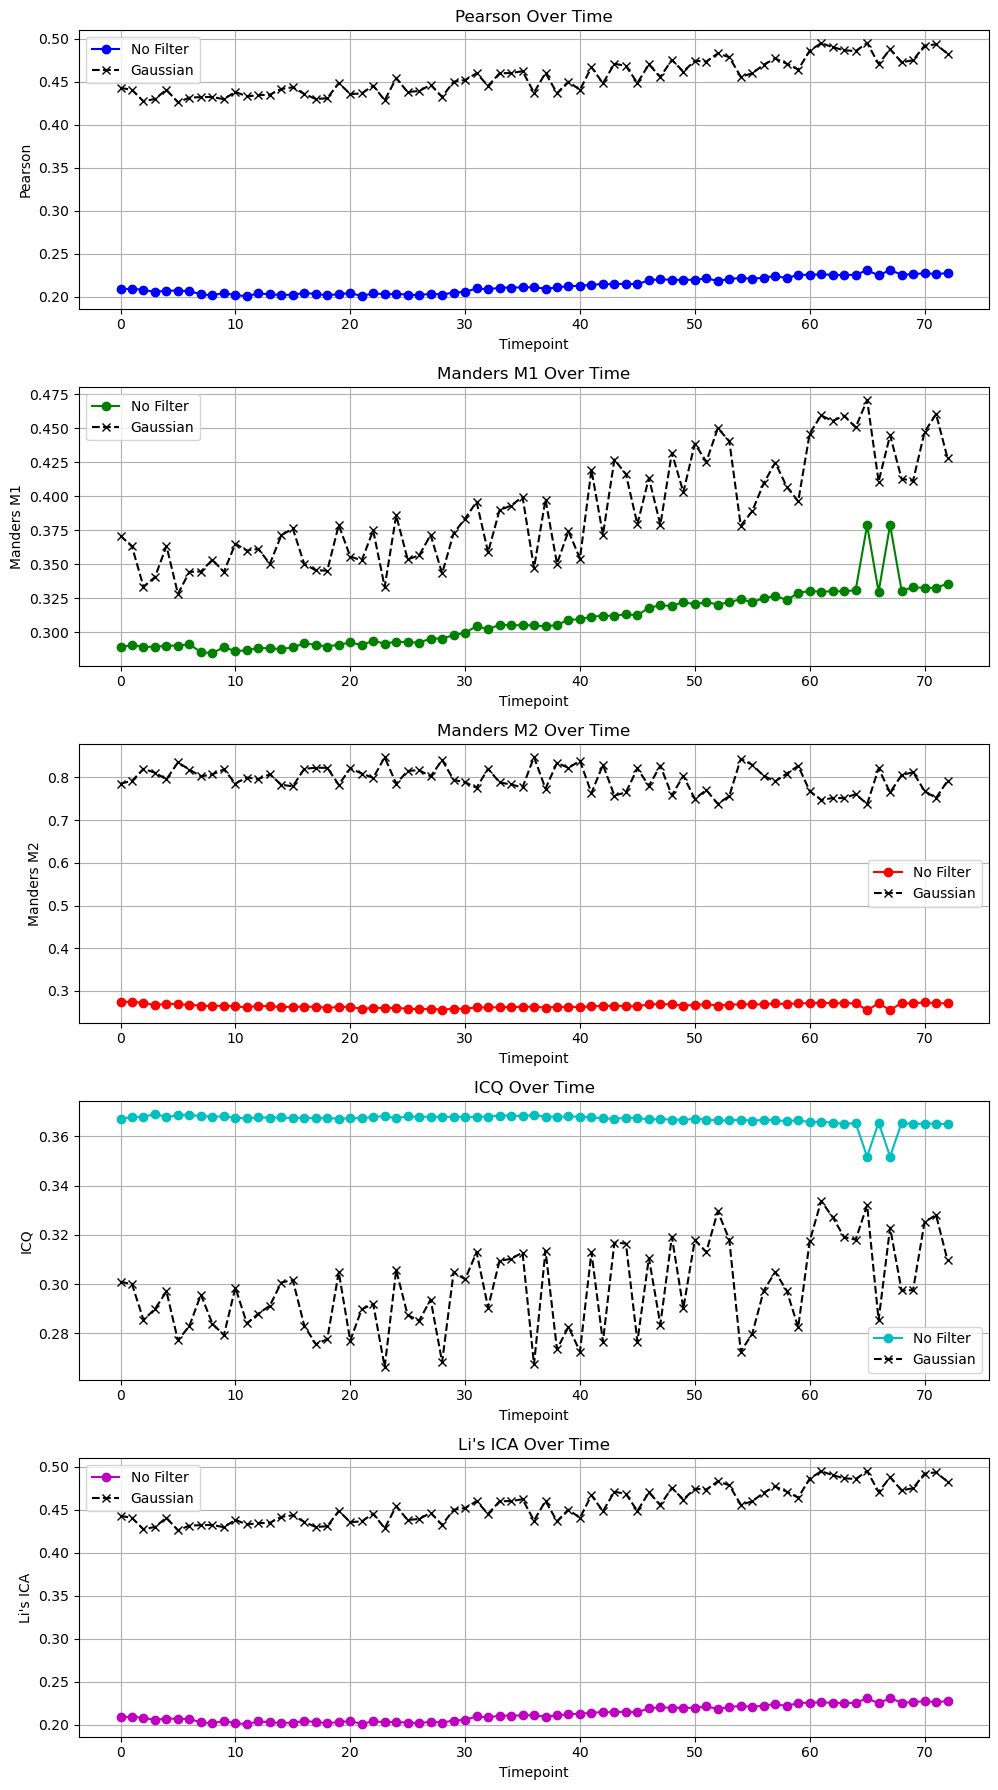

In [41]:
import cupy as cp
import tifffile
import matplotlib.pyplot as plt
from skimage import filters
from scipy.stats import pearsonr
from tqdm import tqdm  # Progress bar

# Load a 5D TIFF file (T, Z, C, Y, X)
def load_5d_tiff(file_path):
    img = tifffile.imread(file_path)  # Load with tifffile
    return cp.asarray(img)  # Convert to CuPy for GPU processing

# Apply a fixed offset to Channel 2
def apply_offset(img, offset):
    """Shift Channel 2 using CuPy roll."""
    return cp.roll(img, shift=offset, axis=(1, 2, 3))  # Apply in (Z, Y, X)

# Apply Otsu thresholding to an image
def otsu_threshold(img):
    threshold = filters.threshold_otsu(cp.asnumpy(img))  # Compute threshold on CPU
    return img > threshold  # Return binary mask (CuPy)

# Preprocess: Gaussian filter + normalize using CuPy
def preprocess_image(img, sigma=1):
    filtered = filters.gaussian(cp.asnumpy(img), sigma=sigma)  # Apply Gaussian filtering on CPU
    return cp.asarray((filtered - filtered.min()) / (filtered.max() - filtered.min()))  # Normalize & return to GPU

# Pearson's Correlation
def compute_pearson_coefficient(ch1, ch2):
    return pearsonr(cp.asnumpy(ch1.flatten()), cp.asnumpy(ch2.flatten()))[0]

# Manders' Coefficients
def compute_manders_coefficients(ch1, ch2):
    mask_ch1 = otsu_threshold(ch1)
    mask_ch2 = otsu_threshold(ch2)

    M1 = cp.sum(ch1[mask_ch2]) / cp.sum(ch1) if cp.sum(ch1) != 0 else 0
    M2 = cp.sum(ch2[mask_ch1]) / cp.sum(ch2) if cp.sum(ch2) != 0 else 0

    return float(M1), float(M2)

# Intensity Correlation Quotient (ICQ)
def compute_icq(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    product = (ch1 - mean_ch1) * (ch2 - mean_ch2)
    icq = cp.sum(product > 0) / product.size - 0.5
    return float(icq)

# Li's ICA
def compute_lis_ica(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    numerator = cp.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
    denominator = cp.sqrt(cp.sum((ch1 - mean_ch1) ** 2) * cp.sum((ch2 - mean_ch2) ** 2))
    return float(numerator / denominator) if denominator != 0 else 0

# Process the 5D stack with different preprocessing
def process_colocalization(file_path, sigma=1, offset=(0, 2, 1)):
    img = load_5d_tiff(file_path)
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    # Apply offset to Channel 2
    img[:, :, 1, :, :] = apply_offset(img[:, :, 1, :, :], offset)

    # Remove last timepoint
    img = img[:-1]
    timepoints = cp.asnumpy(cp.arange(T - 1))  # Convert to NumPy for plotting

    # Initialize lists to store results
    results = {
        "Pearson": {"no_filter": [], "gaussian": []},
        "Manders M1": {"no_filter": [], "gaussian": []},
        "Manders M2": {"no_filter": [], "gaussian": []},
        "ICQ": {"no_filter": [], "gaussian": []},
        "Li's ICA": {"no_filter": [], "gaussian": []}
    }

    # Process each timepoint
    for t in tqdm(range(T - 1), desc="Processing timepoints", unit="frame"):
        ch1 = img[t, :, 0, :, :]  # Channel 1
        ch2 = img[t, :, 1, :, :]  # Channel 2

        # Otsu thresholding on original images
        ch1_thresh, ch2_thresh = otsu_threshold(ch1), otsu_threshold(ch2)

        # With Gaussian filtering
        ch1_gaussian, ch2_gaussian = preprocess_image(ch1, sigma=sigma), preprocess_image(ch2, sigma=sigma)
        ch1_gaussian_thresh, ch2_gaussian_thresh = otsu_threshold(ch1_gaussian), otsu_threshold(ch2_gaussian)

        # Compute metrics
        results["Pearson"]["no_filter"].append(compute_pearson_coefficient(ch1_thresh, ch2_thresh))
        results["Pearson"]["gaussian"].append(compute_pearson_coefficient(ch1_gaussian_thresh, ch2_gaussian_thresh))

        M1, M2 = compute_manders_coefficients(ch1_thresh, ch2_thresh)
        results["Manders M1"]["no_filter"].append(M1)
        results["Manders M2"]["no_filter"].append(M2)

        M1_g, M2_g = compute_manders_coefficients(ch1_gaussian_thresh, ch2_gaussian_thresh)
        results["Manders M1"]["gaussian"].append(M1_g)
        results["Manders M2"]["gaussian"].append(M2_g)

        results["ICQ"]["no_filter"].append(compute_icq(ch1_thresh, ch2_thresh))
        results["ICQ"]["gaussian"].append(compute_icq(ch1_gaussian_thresh, ch2_gaussian_thresh))

        results["Li's ICA"]["no_filter"].append(compute_lis_ica(ch1_thresh, ch2_thresh))
        results["Li's ICA"]["gaussian"].append(compute_lis_ica(ch1_gaussian_thresh, ch2_gaussian_thresh))

    # Compute percentage difference
    for metric in results.keys():
        avg_first_5 = np.mean(results[metric]["no_filter"][:5])
        avg_last_5 = np.mean(results[metric]["no_filter"][-5:])
        percent_diff = ((avg_last_5 - avg_first_5) / avg_first_5) * 100
        print(f"\n🔹 {metric} % Difference (First 5 vs Last 5): {percent_diff:.2f}%")

    # Plot each metric
    fig, axs = plt.subplots(5, 1, figsize=(10, 18))
    colors = ["b", "g", "r", "c", "m"]

    for i, (metric, ax) in enumerate(zip(results.keys(), axs)):
        ax.plot(timepoints, results[metric]["no_filter"], label="No Filter", color=colors[i], marker="o")
        ax.plot(timepoints, results[metric]["gaussian"], label="Gaussian", color="k", linestyle="--", marker="x")

        ax.set_xlabel("Timepoint")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} Over Time")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run the analysis
file_path = r"Z:\Shared299\KinetochoreClub\for Nina\03 PhD lattice movies\20241023 NP_002 MC256 2-colour 4-sec NEBD\Decon 10 iterations\Cell018_Slide 5 capture 3_DC_DS.tif"
process_colocalization(file_path, sigma=1, offset=(0, 2, 1))


Processing timepoints: 100%|████████████████████████████████████████████████████████| 73/73 [04:05<00:00,  3.36s/frame]



🔹 Pearson (no_filter) % Difference: 9.07%
   - t-test p-value: 0.0000
   - Wilcoxon p-value: 0.0625

🔹 Pearson (gaussian) % Difference: 10.74%
   - t-test p-value: 0.0031
   - Wilcoxon p-value: 0.0625

🔹 Manders M1 (no_filter) % Difference: 14.92%
   - t-test p-value: 0.0000
   - Wilcoxon p-value: 0.0625

🔹 Manders M1 (gaussian) % Difference: 21.90%
   - t-test p-value: 0.0091
   - Wilcoxon p-value: 0.0625

🔹 Manders M2 (no_filter) % Difference: -0.06%
   - t-test p-value: 0.9278
   - Wilcoxon p-value: 1.0

🔹 Manders M2 (gaussian) % Difference: -1.85%
   - t-test p-value: 0.4389
   - Wilcoxon p-value: 0.625

🔹 ICQ (no_filter) % Difference: -0.77%
   - t-test p-value: 0.0014
   - Wilcoxon p-value: 0.0625

🔹 ICQ (gaussian) % Difference: 5.75%
   - t-test p-value: 0.1475
   - Wilcoxon p-value: 0.3125

🔹 Li's ICA (no_filter) % Difference: 9.07%
   - t-test p-value: 0.0000
   - Wilcoxon p-value: 0.0625

🔹 Li's ICA (gaussian) % Difference: 10.74%
   - t-test p-value: 0.0031
   - Wilcoxon p-

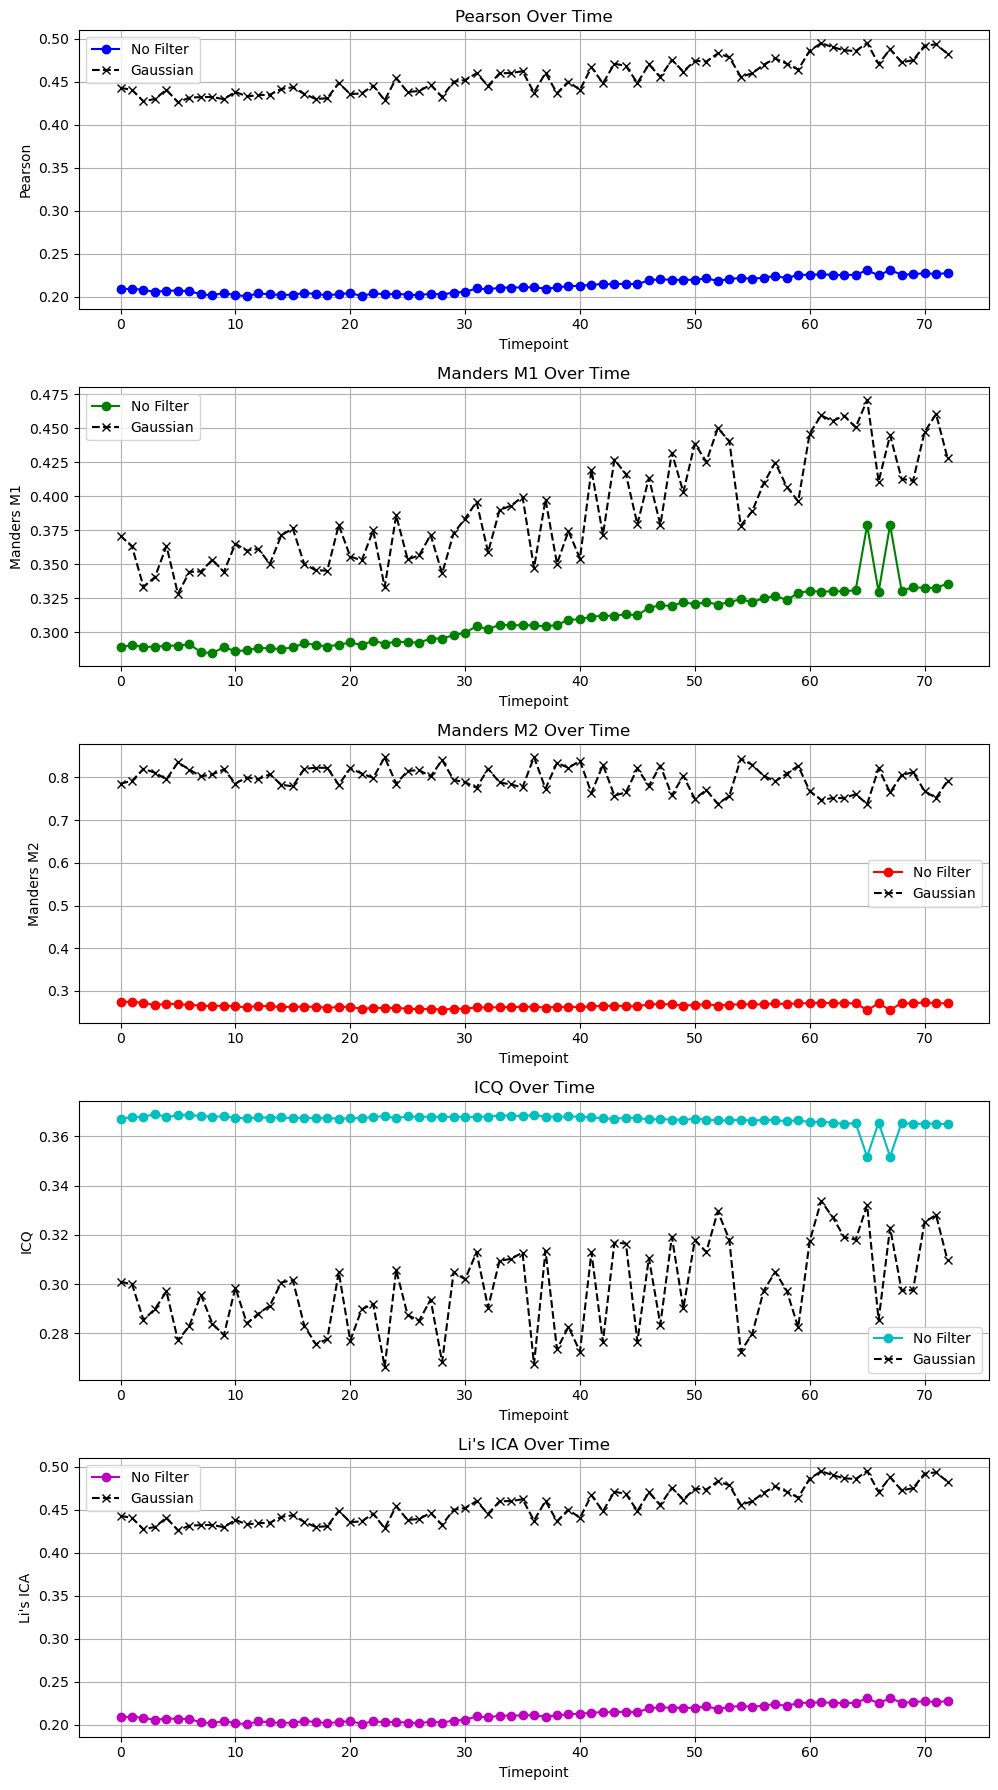

In [43]:
import cupy as cp
import tifffile
import matplotlib.pyplot as plt
from skimage import filters
from scipy.stats import pearsonr, ttest_rel, wilcoxon
from tqdm import tqdm  # Progress bar
import numpy as np

# Load a 5D TIFF file (T, Z, C, Y, X)
def load_5d_tiff(file_path):
    img = tifffile.imread(file_path)  # Load with tifffile
    return cp.asarray(img)  # Convert to CuPy for GPU processing

# Apply a fixed offset to Channel 2
def apply_offset(img, offset):
    """Shift Channel 2 using CuPy roll."""
    return cp.roll(img, shift=offset, axis=(1, 2, 3))  # Apply in (Z, Y, X)

# Apply Otsu thresholding to an image
def otsu_threshold(img):
    threshold = filters.threshold_otsu(cp.asnumpy(img))  # Compute threshold on CPU
    return img > threshold  # Return binary mask (CuPy)

# Preprocess: Gaussian filter + normalize using CuPy
def preprocess_image(img, sigma=1):
    filtered = filters.gaussian(cp.asnumpy(img), sigma=sigma)  # Apply Gaussian filtering on CPU
    return cp.asarray((filtered - filtered.min()) / (filtered.max() - filtered.min()))  # Normalize & return to GPU

# Pearson's Correlation
def compute_pearson_coefficient(ch1, ch2):
    return pearsonr(cp.asnumpy(ch1.flatten()), cp.asnumpy(ch2.flatten()))[0]

# Manders' Coefficients
def compute_manders_coefficients(ch1, ch2):
    mask_ch1 = otsu_threshold(ch1)
    mask_ch2 = otsu_threshold(ch2)

    M1 = cp.sum(ch1[mask_ch2]) / cp.sum(ch1) if cp.sum(ch1) != 0 else 0
    M2 = cp.sum(ch2[mask_ch1]) / cp.sum(ch2) if cp.sum(ch2) != 0 else 0

    return float(M1), float(M2)

# Intensity Correlation Quotient (ICQ)
def compute_icq(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    product = (ch1 - mean_ch1) * (ch2 - mean_ch2)
    icq = cp.sum(product > 0) / product.size - 0.5
    return float(icq)

# Li's ICA
def compute_lis_ica(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    numerator = cp.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
    denominator = cp.sqrt(cp.sum((ch1 - mean_ch1) ** 2) * cp.sum((ch2 - mean_ch2) ** 2))
    return float(numerator / denominator) if denominator != 0 else 0

# Process the 5D stack with different preprocessing
def process_colocalization(file_path, sigma=1, offset=(0, 2, 1), apply_shift=True):
    img = load_5d_tiff(file_path)
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    # Store the original image for comparison
    img_original = img.copy()

    if apply_shift:
        # Apply offset to Channel 2
        img[:, :, 1, :, :] = apply_offset(img[:, :, 1, :, :], offset)

    # Remove last timepoint
    img = img[:-1]
    img_original = img_original[:-1]
    timepoints = cp.asnumpy(cp.arange(T - 1))  # Convert to NumPy for plotting

    # Initialize lists to store results
    results = {
        "Pearson": {"no_filter": [], "gaussian": []},
        "Manders M1": {"no_filter": [], "gaussian": []},
        "Manders M2": {"no_filter": [], "gaussian": []},
        "ICQ": {"no_filter": [], "gaussian": []},
        "Li's ICA": {"no_filter": [], "gaussian": []}
    }

    # Process each timepoint
    for t in tqdm(range(T - 1), desc="Processing timepoints", unit="frame"):
        ch1 = img[t, :, 0, :, :]
        ch2 = img[t, :, 1, :, :]

        # Otsu thresholding on original images
        ch1_thresh, ch2_thresh = otsu_threshold(ch1), otsu_threshold(ch2)

        # With Gaussian filtering
        ch1_gaussian, ch2_gaussian = preprocess_image(ch1, sigma=sigma), preprocess_image(ch2, sigma=sigma)
        ch1_gaussian_thresh, ch2_gaussian_thresh = otsu_threshold(ch1_gaussian), otsu_threshold(ch2_gaussian)

        # Compute metrics
        results["Pearson"]["no_filter"].append(compute_pearson_coefficient(ch1_thresh, ch2_thresh))
        results["Pearson"]["gaussian"].append(compute_pearson_coefficient(ch1_gaussian_thresh, ch2_gaussian_thresh))

        M1, M2 = compute_manders_coefficients(ch1_thresh, ch2_thresh)
        results["Manders M1"]["no_filter"].append(M1)
        results["Manders M2"]["no_filter"].append(M2)

        M1_g, M2_g = compute_manders_coefficients(ch1_gaussian_thresh, ch2_gaussian_thresh)
        results["Manders M1"]["gaussian"].append(M1_g)
        results["Manders M2"]["gaussian"].append(M2_g)

        results["ICQ"]["no_filter"].append(compute_icq(ch1_thresh, ch2_thresh))
        results["ICQ"]["gaussian"].append(compute_icq(ch1_gaussian_thresh, ch2_gaussian_thresh))

        results["Li's ICA"]["no_filter"].append(compute_lis_ica(ch1_thresh, ch2_thresh))
        results["Li's ICA"]["gaussian"].append(compute_lis_ica(ch1_gaussian_thresh, ch2_gaussian_thresh))

    # Compute percentage difference and statistical tests
    for metric in results.keys():
        for filter_type in ["no_filter", "gaussian"]:
            avg_first_5 = np.mean(results[metric][filter_type][:5])
            avg_last_5 = np.mean(results[metric][filter_type][-5:])
            percent_diff = ((avg_last_5 - avg_first_5) / avg_first_5) * 100

            # Perform t-test and Wilcoxon test
            t_stat, t_p = ttest_rel(results[metric][filter_type][:5], results[metric][filter_type][-5:])
            try:
                w_stat, w_p = wilcoxon(results[metric][filter_type][:5], results[metric][filter_type][-5:])
            except ValueError:
                w_stat, w_p = None, None  # Wilcoxon test fails if all values are identical

            print(f"\n🔹 {metric} ({filter_type}) % Difference: {percent_diff:.2f}%")
            print(f"   - t-test p-value: {t_p:.4f}")
            print(f"   - Wilcoxon p-value: {w_p if w_p is not None else 'N/A'}")

    # Plot each metric
    fig, axs = plt.subplots(5, 1, figsize=(10, 18))
    colors = ["b", "g", "r", "c", "m"]

    for i, (metric, ax) in enumerate(zip(results.keys(), axs)):
        ax.plot(timepoints, results[metric]["no_filter"], label="No Filter", color=colors[i], marker="o")
        ax.plot(timepoints, results[metric]["gaussian"], label="Gaussian", color="k", linestyle="--", marker="x")

        ax.set_xlabel("Timepoint")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} Over Time")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run analysis
file_path = r"Z:\Shared299\KinetochoreClub\for Nina\03 PhD lattice movies\20241023 NP_002 MC256 2-colour 4-sec NEBD\Decon 10 iterations\Cell018_Slide 5 capture 3_DC_DS.tif"
process_colocalization(file_path, sigma=1, offset=(0, 2, 1), apply_shift=True)


Processing timepoints: 100%|████████████████████████████████████████████████████████| 73/73 [03:42<00:00,  3.05s/frame]



🔹 Pearson (no_filter) % Difference: 8.28%
   - t-test p-value: 0.0002
   - Wilcoxon p-value: 0.0625

🔹 Pearson (gaussian) % Difference: 10.56%
   - t-test p-value: 0.0034
   - Wilcoxon p-value: 0.0625

🔹 Manders M1 (no_filter) % Difference: 14.34%
   - t-test p-value: 0.0000
   - Wilcoxon p-value: 0.0625

🔹 Manders M1 (gaussian) % Difference: 21.76%
   - t-test p-value: 0.0094
   - Wilcoxon p-value: 0.0625

🔹 Manders M2 (no_filter) % Difference: -0.56%
   - t-test p-value: 0.4853
   - Wilcoxon p-value: 0.3125

🔹 Manders M2 (gaussian) % Difference: -1.94%
   - t-test p-value: 0.4148
   - Wilcoxon p-value: 0.625

🔹 ICQ (no_filter) % Difference: -0.85%
   - t-test p-value: 0.0004
   - Wilcoxon p-value: 0.0625

🔹 ICQ (gaussian) % Difference: 5.67%
   - t-test p-value: 0.1521
   - Wilcoxon p-value: 0.3125

🔹 Li's ICA (no_filter) % Difference: 8.28%
   - t-test p-value: 0.0002
   - Wilcoxon p-value: 0.0625

🔹 Li's ICA (gaussian) % Difference: 10.56%
   - t-test p-value: 0.0034
   - Wilcoxon

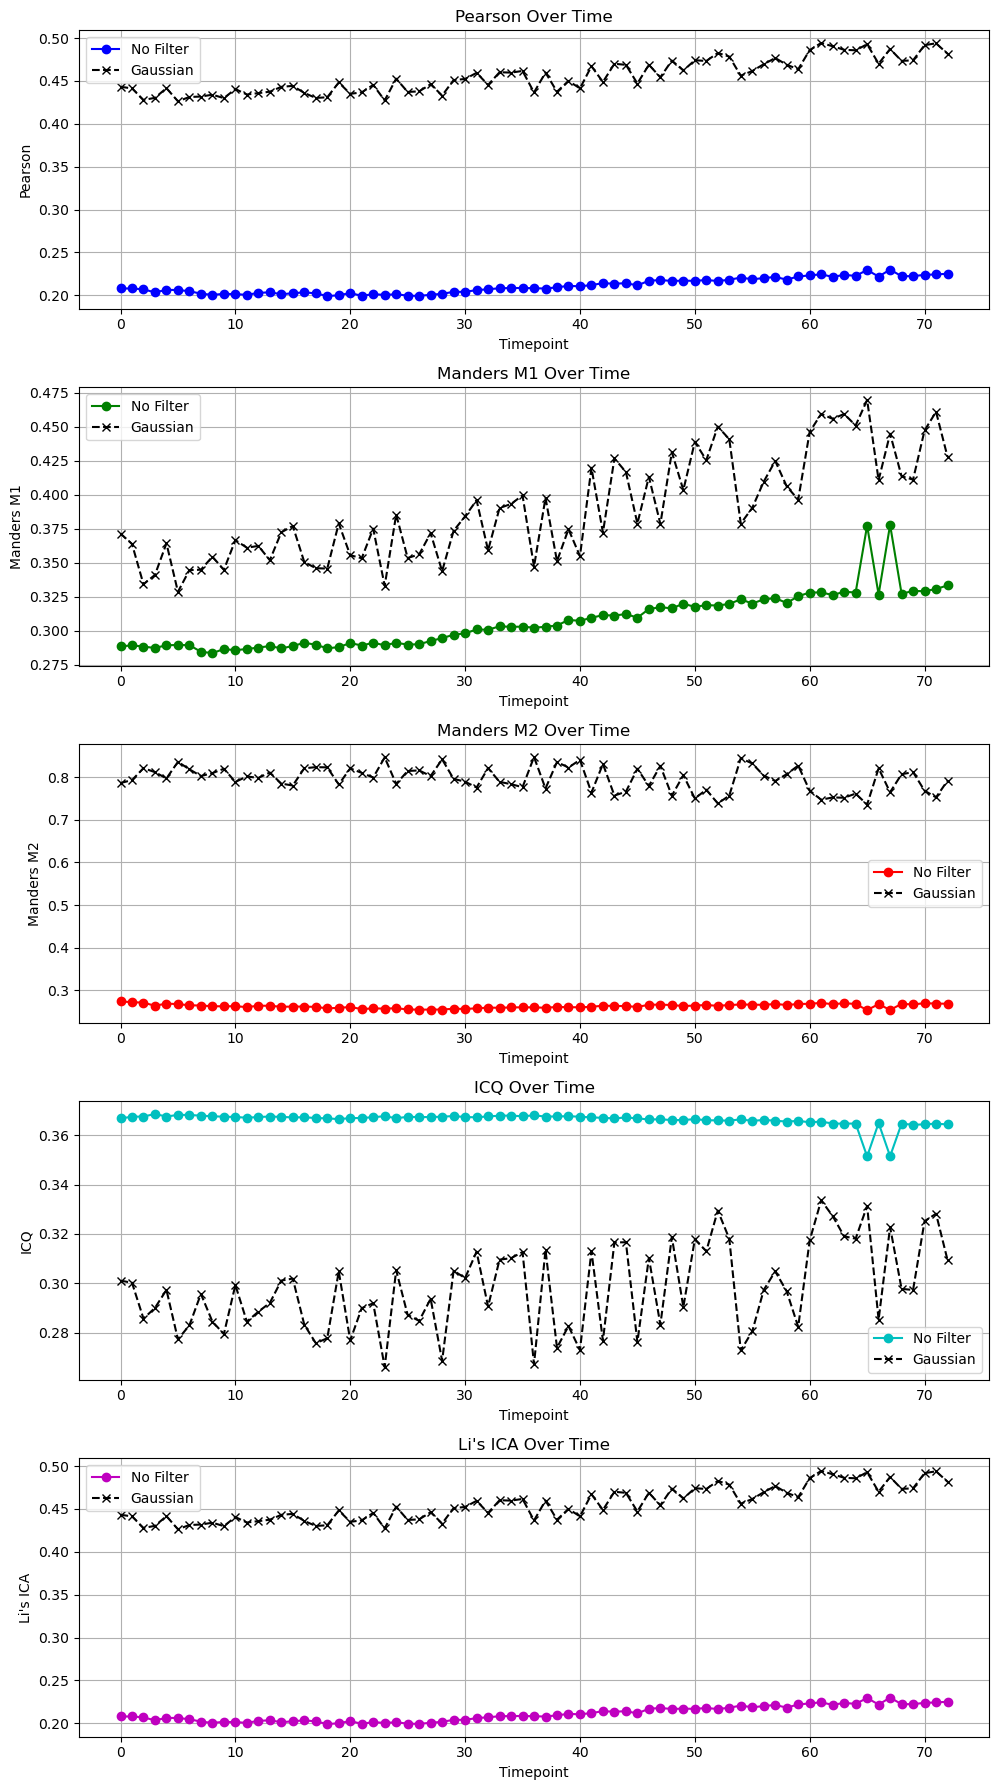

In [44]:
process_colocalization(file_path, sigma=1, offset=(0, 2, 1), apply_shift=False)

In [42]:
import cupy as cp
import tifffile
import matplotlib.pyplot as plt
from skimage import filters
from scipy.stats import pearsonr, ttest_rel, wilcoxon
from tqdm import tqdm  # Progress bar
import numpy as np

# Load a 5D TIFF file (T, Z, C, Y, X)
def load_5d_tiff(file_path):
    img = tifffile.imread(file_path)  # Load with tifffile
    return cp.asarray(img)  # Convert to CuPy for GPU processing

# Apply a fixed offset to Channel 2
def apply_offset(img, offset):
    """Shift Channel 2 using CuPy roll."""
    return cp.roll(img, shift=offset, axis=(1, 2, 3))  # Apply in (Z, Y, X)

# Apply Otsu thresholding to an image
def otsu_threshold(img):
    threshold = filters.threshold_otsu(cp.asnumpy(img))  # Compute threshold on CPU
    return img > threshold  # Return binary mask (CuPy)

# Preprocess: Gaussian filter + normalize using CuPy
def preprocess_image(img, sigma=1):
    filtered = filters.gaussian(cp.asnumpy(img), sigma=sigma)  # Apply Gaussian filtering on CPU
    return cp.asarray((filtered - filtered.min()) / (filtered.max() - filtered.min()))  # Normalize & return to GPU

# Pearson's Correlation
def compute_pearson_coefficient(ch1, ch2):
    return pearsonr(cp.asnumpy(ch1.flatten()), cp.asnumpy(ch2.flatten()))[0]

# Manders' Coefficients
def compute_manders_coefficients(ch1, ch2):
    mask_ch1 = otsu_threshold(ch1)
    mask_ch2 = otsu_threshold(ch2)

    M1 = cp.sum(ch1[mask_ch2]) / cp.sum(ch1) if cp.sum(ch1) != 0 else 0
    M2 = cp.sum(ch2[mask_ch1]) / cp.sum(ch2) if cp.sum(ch2) != 0 else 0

    return float(M1), float(M2)

# Intensity Correlation Quotient (ICQ)
def compute_icq(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    product = (ch1 - mean_ch1) * (ch2 - mean_ch2)
    icq = cp.sum(product > 0) / product.size - 0.5
    return float(icq)

# Li's ICA
def compute_lis_ica(ch1, ch2):
    mean_ch1, mean_ch2 = ch1.mean(), ch2.mean()
    numerator = cp.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
    denominator = cp.sqrt(cp.sum((ch1 - mean_ch1) ** 2) * cp.sum((ch2 - mean_ch2) ** 2))
    return float(numerator / denominator) if denominator != 0 else 0

# Process the 5D stack with different preprocessing
def process_colocalization(file_path, sigma=1, offset=(0, 2, 1), apply_shift=True):
    img = load_5d_tiff(file_path)
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    # Store the original image for comparison
    img_original = img.copy()

    if apply_shift:
        # Apply offset to Channel 2
        img[:, :, 1, :, :] = apply_offset(img[:, :, 1, :, :], offset)

    # Remove last timepoint
    img = img[:-1]
    img_original = img_original[:-1]
    timepoints = cp.asnumpy(cp.arange(T - 1))  # Convert to NumPy for plotting

    # Initialize lists to store results
    results = {
        "Pearson": {"no_filter": [], "gaussian": []},
        "Manders M1": {"no_filter": [], "gaussian": []},
        "Manders M2": {"no_filter": [], "gaussian": []},
        "ICQ": {"no_filter": [], "gaussian": []},
        "Li's ICA": {"no_filter": [], "gaussian": []}
    }

    # Process each timepoint
    for t in tqdm(range(T - 1), desc="Processing timepoints", unit="frame"):
        ch1 = img[t, :, 0, :, :]
        ch2 = img[t, :, 1, :, :]

        # Otsu thresholding on original images
        ch1_thresh, ch2_thresh = otsu_threshold(ch1), otsu_threshold(ch2)

        # With Gaussian filtering
        ch1_gaussian, ch2_gaussian = preprocess_image(ch1, sigma=sigma), preprocess_image(ch2, sigma=sigma)
        ch1_gaussian_thresh, ch2_gaussian_thresh = otsu_threshold(ch1_gaussian), otsu_threshold(ch2_gaussian)

        # Compute metrics
        results["Pearson"]["no_filter"].append(compute_pearson_coefficient(ch1_thresh, ch2_thresh))
        results["Pearson"]["gaussian"].append(compute_pearson_coefficient(ch1_gaussian_thresh, ch2_gaussian_thresh))

        M1, M2 = compute_manders_coefficients(ch1_thresh, ch2_thresh)
        results["Manders M1"]["no_filter"].append(M1)
        results["Manders M2"]["no_filter"].append(M2)

        M1_g, M2_g = compute_manders_coefficients(ch1_gaussian_thresh, ch2_gaussian_thresh)
        results["Manders M1"]["gaussian"].append(M1_g)
        results["Manders M2"]["gaussian"].append(M2_g)

        results["ICQ"]["no_filter"].append(compute_icq(ch1_thresh, ch2_thresh))
        results["ICQ"]["gaussian"].append(compute_icq(ch1_gaussian_thresh, ch2_gaussian_thresh))

        results["Li's ICA"]["no_filter"].append(compute_lis_ica(ch1_thresh, ch2_thresh))
        results["Li's ICA"]["gaussian"].append(compute_lis_ica(ch1_gaussian_thresh, ch2_gaussian_thresh))

    # Compute percentage difference and statistical tests
    for metric in results.keys():
        for filter_type in ["no_filter", "gaussian"]:
            avg_first_5 = np.mean(results[metric][filter_type][:5])
            avg_last_5 = np.mean(results[metric][filter_type][-5:])
            percent_diff = ((avg_last_5 - avg_first_5) / avg_first_5) * 100

            # Perform t-test and Wilcoxon test
            t_stat, t_p = ttest_rel(results[metric][filter_type][:5], results[metric][filter_type][-5:])
            try:
                w_stat, w_p = wilcoxon(results[metric][filter_type][:5], results[metric][filter_type][-5:])
            except ValueError:
                w_stat, w_p = None, None  # Wilcoxon test fails if all values are identical

            print(f"\n🔹 {metric} ({filter_type}) % Difference: {percent_diff:.2f}%")
            print(f"   - t-test p-value: {t_p:.4f}")
            print(f"   - Wilcoxon p-value: {w_p if w_p is not None else 'N/A'}")

    # Plot each metric
    fig, axs = plt.subplots(5, 1, figsize=(10, 18))
    colors = ["b", "g", "r", "c", "m"]

    for i, (metric, ax) in enumerate(zip(results.keys(), axs)):
        ax.plot(timepoints, results[metric]["no_filter"], label="No Filter", color=colors[i], marker="o")
        ax.plot(timepoints, results[metric]["gaussian"], label="Gaussian", color="k", linestyle="--", marker="x")

        ax.set_xlabel("Timepoint")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} Over Time")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run analysis with and without offset
file_path = "sample_5D_tzcyx.tif"
print("\n--- Results WITH Offset ---")
process_colocalization(file_path, sigma=1, offset=(0, 2, 1), apply_shift=True)

print("\n--- Results WITHOUT Offset ---")
process_colocalization(file_path, sigma=1, offset=(0, 2, 1), apply_shift=False)



--- Results WITH Offset ---


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Scott\\GitHub\\KiTtoNapari\\sample_5D_tzcyx.tif'

## Offset between channels

In [38]:
import cupy as cp
import tifffile
import numpy as np
from tqdm import tqdm  # Progress bar

# Normalize images to the range [0, 1]
def normalize_image(img):
    img_min = cp.min(img)
    img_max = cp.max(img)
    return (img - img_min) / (img_max - img_min + 1e-9)  # Avoid division by zero

# Compute 3D phase correlation to find offset
def compute_3d_offset(ch1, ch2):
    """Find the 3D translation offset between two images using FFT-based phase correlation."""
    # Normalize images before FFT
    ch1_norm = normalize_image(ch1)
    ch2_norm = normalize_image(ch2)

    # Compute Fourier transform
    f1 = cp.fft.fftn(ch1_norm)
    f2 = cp.fft.fftn(ch2_norm)
    
    # Compute normalized cross-power spectrum
    cross_power_spectrum = f1 * cp.conj(f2)
    cross_power_spectrum /= cp.abs(cross_power_spectrum) + 1e-9  # Avoid division by zero

    # Compute inverse FFT to get phase correlation
    correlation = cp.fft.ifftn(cross_power_spectrum).real

    # **Fix: Apply FFT shift to correctly align the correlation matrix**
    correlation = cp.fft.fftshift(correlation)

    # Find peak correlation (offset)
    shift = cp.unravel_index(cp.argmax(correlation), correlation.shape)

    # **Correct the shift relative to the center**
    center = cp.array(correlation.shape) // 2
    offset = cp.array(shift) - center
    
    return tuple(cp.asnumpy(offset))  # Convert to NumPy for printing

# Process the 5D stack and compute offsets over time
def process_channel_offsets(img):
    img = cp.asarray(img)  # Ensure the data is on GPU
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    offsets = []

    print("\n3D Channel Offsets Per Timepoint:\n")
    
    # Process each timepoint
    for t in tqdm(range(T), desc="Processing timepoints", unit="frame"):
        ch1 = img[t, :, 0, :, :]  # Channel 1
        ch2 = img[t, :, 1, :, :]  # Channel 2
        
        offset = compute_3d_offset(ch1, ch2)
        offsets.append(offset)
        
        print(f"Time {t}: Offset (ΔZ, ΔY, ΔX) = {offset}")

    # Compute average offset across time
    offsets = np.array(offsets)
    avg_offset = np.mean(offsets, axis=0)

    print("\n🔹 Average Offset Over Time (ΔZ, ΔY, ΔX):", tuple(avg_offset))

# Run the offset computation
process_channel_offsets(data[:-1])  # Ensure correct data input



3D Channel Offsets Per Timepoint:



Processing timepoints:   3%|█▌                                                       | 2/73 [00:01<00:34,  2.04frame/s]

Time 0: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 1: Offset (ΔZ, ΔY, ΔX) = (-1, 0, 1)


Processing timepoints:   5%|███                                                      | 4/73 [00:01<00:16,  4.23frame/s]

Time 2: Offset (ΔZ, ΔY, ΔX) = (0, 3, 0)
Time 3: Offset (ΔZ, ΔY, ΔX) = (-2, 6, -9)


Processing timepoints:   8%|████▋                                                    | 6/73 [00:01<00:11,  6.06frame/s]

Time 4: Offset (ΔZ, ΔY, ΔX) = (0, 1, 2)
Time 5: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  11%|██████▏                                                  | 8/73 [00:01<00:08,  7.30frame/s]

Time 6: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 7: Offset (ΔZ, ΔY, ΔX) = (0, 3, 1)


Processing timepoints:  14%|███████▋                                                | 10/73 [00:02<00:07,  8.05frame/s]

Time 8: Offset (ΔZ, ΔY, ΔX) = (0, 3, 0)
Time 9: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  16%|█████████▏                                              | 12/73 [00:02<00:07,  8.44frame/s]

Time 10: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 11: Offset (ΔZ, ΔY, ΔX) = (0, 2, 2)


Processing timepoints:  19%|██████████▋                                             | 14/73 [00:02<00:06,  8.65frame/s]

Time 12: Offset (ΔZ, ΔY, ΔX) = (0, 1, 2)
Time 13: Offset (ΔZ, ΔY, ΔX) = (-1, 1, 0)


Processing timepoints:  22%|████████████▎                                           | 16/73 [00:02<00:06,  8.77frame/s]

Time 14: Offset (ΔZ, ΔY, ΔX) = (0, 2, 3)
Time 15: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  25%|█████████████▊                                          | 18/73 [00:02<00:06,  8.80frame/s]

Time 16: Offset (ΔZ, ΔY, ΔX) = (0, 1, 2)
Time 17: Offset (ΔZ, ΔY, ΔX) = (0, 0, 0)


Processing timepoints:  27%|███████████████▎                                        | 20/73 [00:03<00:05,  8.84frame/s]

Time 18: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)
Time 19: Offset (ΔZ, ΔY, ΔX) = (0, 3, 0)


Processing timepoints:  30%|████████████████▉                                       | 22/73 [00:03<00:05,  8.83frame/s]

Time 20: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 21: Offset (ΔZ, ΔY, ΔX) = (-1, 2, 0)


Processing timepoints:  33%|██████████████████▍                                     | 24/73 [00:03<00:05,  8.86frame/s]

Time 22: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 23: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  36%|███████████████████▉                                    | 26/73 [00:03<00:05,  8.73frame/s]

Time 24: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 25: Offset (ΔZ, ΔY, ΔX) = (-1, 2, 0)


Processing timepoints:  38%|█████████████████████▍                                  | 28/73 [00:04<00:05,  8.66frame/s]

Time 26: Offset (ΔZ, ΔY, ΔX) = (0, 3, 0)
Time 27: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  41%|███████████████████████                                 | 30/73 [00:04<00:04,  8.73frame/s]

Time 28: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)
Time 29: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  44%|████████████████████████▌                               | 32/73 [00:04<00:04,  8.78frame/s]

Time 30: Offset (ΔZ, ΔY, ΔX) = (-1, 1, 1)
Time 31: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  47%|██████████████████████████                              | 34/73 [00:04<00:04,  8.85frame/s]

Time 32: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 33: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  49%|███████████████████████████▌                            | 36/73 [00:04<00:04,  8.84frame/s]

Time 34: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 35: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  52%|█████████████████████████████▏                          | 38/73 [00:05<00:04,  8.67frame/s]

Time 36: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 37: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  55%|██████████████████████████████▋                         | 40/73 [00:05<00:03,  8.68frame/s]

Time 38: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 39: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  58%|████████████████████████████████▏                       | 42/73 [00:05<00:03,  8.79frame/s]

Time 40: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 41: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  60%|█████████████████████████████████▊                      | 44/73 [00:05<00:03,  8.83frame/s]

Time 42: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 43: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  63%|███████████████████████████████████▎                    | 46/73 [00:06<00:03,  8.86frame/s]

Time 44: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 45: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  66%|████████████████████████████████████▊                   | 48/73 [00:06<00:02,  8.71frame/s]

Time 46: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 47: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  68%|██████████████████████████████████████▎                 | 50/73 [00:06<00:02,  8.53frame/s]

Time 48: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 49: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  71%|███████████████████████████████████████▉                | 52/73 [00:06<00:02,  8.71frame/s]

Time 50: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 51: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  74%|█████████████████████████████████████████▍              | 54/73 [00:07<00:02,  8.77frame/s]

Time 52: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 53: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  77%|██████████████████████████████████████████▉             | 56/73 [00:07<00:01,  8.81frame/s]

Time 54: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 55: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  79%|████████████████████████████████████████████▍           | 58/73 [00:07<00:01,  8.81frame/s]

Time 56: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 57: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  82%|██████████████████████████████████████████████          | 60/73 [00:07<00:01,  8.84frame/s]

Time 58: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 59: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  85%|███████████████████████████████████████████████▌        | 62/73 [00:07<00:01,  8.61frame/s]

Time 60: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 61: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  88%|█████████████████████████████████████████████████       | 64/73 [00:08<00:01,  8.72frame/s]

Time 62: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 63: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  90%|██████████████████████████████████████████████████▋     | 66/73 [00:08<00:00,  8.74frame/s]

Time 64: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 65: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  93%|████████████████████████████████████████████████████▏   | 68/73 [00:08<00:00,  8.86frame/s]

Time 66: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)
Time 67: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  96%|█████████████████████████████████████████████████████▋  | 70/73 [00:08<00:00,  8.94frame/s]

Time 68: Offset (ΔZ, ΔY, ΔX) = (-1, 2, 1)
Time 69: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  99%|███████████████████████████████████████████████████████▏| 72/73 [00:09<00:00,  8.97frame/s]

Time 70: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)
Time 71: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints: 100%|████████████████████████████████████████████████████████| 73/73 [00:09<00:00,  7.93frame/s]

Time 72: Offset (ΔZ, ΔY, ΔX) = (-1, 2, 1)

🔹 Average Offset Over Time (ΔZ, ΔY, ΔX): (-0.1232876712328767, 1.8767123287671232, 0.6575342465753424)


## CPU cross correlation

In [39]:
import numpy as np
import tifffile
import scipy.signal
from tqdm import tqdm  # Progress bar

# Load a 5D TIFF file (T, Z, C, Y, X)
def load_5d_tiff(file_path):
    img = tifffile.imread(file_path)  # Load with tifffile (CPU)
    return img  # Keep as NumPy array (CPU-based)

# Compute 3D cross-correlation to find offset
def compute_3d_offset(ch1, ch2):
    """Find the 3D translation offset between two images using cross-correlation."""
    correlation = scipy.signal.correlate(ch1, ch2, mode="full", method="auto")  # Compute 3D cross-correlation
    shift = np.unravel_index(np.argmax(correlation), correlation.shape)  # Find peak
    offset = np.array(shift) - np.array(correlation.shape) // 2
    return tuple(offset)  # Return NumPy tuple

# Process the 5D stack and compute offsets over time
def process_channel_offsets(img):
    # img = load_5d_tiff(file_path)
    T, Z, C, Y, X = img.shape
    assert C == 2, "Expected a 2-channel image."

    offsets = []

    print("\n3D Channel Offsets Per Timepoint:\n")
    
    # Process each timepoint

    for t in tqdm(range(T), desc="Processing timepoints", unit="frame"):
        ch1 = img[t, :, 0, :, :]  # Channel 1
        ch2 = img[t, :, 1, :, :]  # Channel 2
        ch1 = (ch1 - np.min(ch1)) / (np.max(ch1) - np.min(ch1))
        ch2 = (ch2 - np.min(ch2)) / (np.max(ch2) - np.min(ch2))

        
        offset = compute_3d_offset(ch1, ch2)
        offsets.append(offset)
        
        print(f"Time {t}: Offset (ΔZ, ΔY, ΔX) = {offset}")

    # Compute average offset across time
    offsets = np.array(offsets)
    avg_offset = np.mean(offsets, axis=0)

    print("\n🔹 Average Offset Over Time (ΔZ, ΔY, ΔX):", tuple(avg_offset))

# Run the offset computation
file_path = r"Z:\Shared299\KinetochoreClub\for Nina\03 PhD lattice movies\20241023 NP_002 MC256 2-colour 4-sec NEBD\Decon 10 iterations\Cell018_Slide 5 capture 3_DC_DS.tif"
process_channel_offsets(data[:-1])



3D Channel Offsets Per Timepoint:



Processing timepoints:   1%|▊                                                        | 1/73 [00:09<11:17,  9.41s/frame]

Time 0: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:   3%|█▌                                                       | 2/73 [00:19<11:19,  9.57s/frame]

Time 1: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:   4%|██▎                                                      | 3/73 [00:28<11:14,  9.64s/frame]

Time 2: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:   5%|███                                                      | 4/73 [00:38<10:56,  9.52s/frame]

Time 3: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:   7%|███▉                                                     | 5/73 [00:47<10:42,  9.45s/frame]

Time 4: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:   8%|████▋                                                    | 6/73 [00:56<10:26,  9.36s/frame]

Time 5: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  10%|█████▍                                                   | 7/73 [01:06<10:22,  9.43s/frame]

Time 6: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  11%|██████▏                                                  | 8/73 [01:15<10:06,  9.32s/frame]

Time 7: Offset (ΔZ, ΔY, ΔX) = (0, 2, 0)


Processing timepoints:  12%|███████                                                  | 9/73 [01:24<09:51,  9.24s/frame]

Time 8: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  14%|███████▋                                                | 10/73 [01:33<09:38,  9.18s/frame]

Time 9: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  15%|████████▍                                               | 11/73 [01:42<09:27,  9.15s/frame]

Time 10: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  16%|█████████▏                                              | 12/73 [01:51<09:20,  9.18s/frame]

Time 11: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  18%|█████████▉                                              | 13/73 [02:01<09:13,  9.22s/frame]

Time 12: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  19%|██████████▋                                             | 14/73 [02:10<09:07,  9.29s/frame]

Time 13: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  21%|███████████▌                                            | 15/73 [02:19<08:58,  9.28s/frame]

Time 14: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  22%|████████████▎                                           | 16/73 [02:29<08:51,  9.32s/frame]

Time 15: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  23%|█████████████                                           | 17/73 [02:38<08:43,  9.34s/frame]

Time 16: Offset (ΔZ, ΔY, ΔX) = (0, 0, 1)


Processing timepoints:  25%|█████████████▊                                          | 18/73 [02:47<08:30,  9.28s/frame]

Time 17: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  26%|██████████████▌                                         | 19/73 [02:56<08:21,  9.28s/frame]

Time 18: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  27%|███████████████▎                                        | 20/73 [03:06<08:11,  9.27s/frame]

Time 19: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  29%|████████████████                                        | 21/73 [03:15<08:02,  9.27s/frame]

Time 20: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  30%|████████████████▉                                       | 22/73 [03:24<07:50,  9.23s/frame]

Time 21: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  32%|█████████████████▋                                      | 23/73 [03:33<07:38,  9.17s/frame]

Time 22: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  33%|██████████████████▍                                     | 24/73 [03:42<07:28,  9.15s/frame]

Time 23: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  34%|███████████████████▏                                    | 25/73 [03:52<07:20,  9.18s/frame]

Time 24: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  36%|███████████████████▉                                    | 26/73 [04:01<07:12,  9.21s/frame]

Time 25: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  37%|████████████████████▋                                   | 27/73 [04:10<07:06,  9.26s/frame]

Time 26: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  38%|█████████████████████▍                                  | 28/73 [04:20<07:02,  9.38s/frame]

Time 27: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  40%|██████████████████████▏                                 | 29/73 [04:29<06:55,  9.44s/frame]

Time 28: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  41%|███████████████████████                                 | 30/73 [04:39<06:44,  9.40s/frame]

Time 29: Offset (ΔZ, ΔY, ΔX) = (0, 1, 1)


Processing timepoints:  42%|███████████████████████▊                                | 31/73 [04:48<06:33,  9.37s/frame]

Time 30: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  44%|████████████████████████▌                               | 32/73 [04:57<06:23,  9.36s/frame]

Time 31: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  45%|█████████████████████████▎                              | 33/73 [05:07<06:13,  9.35s/frame]

Time 32: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  47%|██████████████████████████                              | 34/73 [05:16<06:04,  9.34s/frame]

Time 33: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  48%|██████████████████████████▊                             | 35/73 [05:25<05:54,  9.33s/frame]

Time 34: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  49%|███████████████████████████▌                            | 36/73 [05:35<05:48,  9.43s/frame]

Time 35: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  51%|████████████████████████████▍                           | 37/73 [05:44<05:37,  9.38s/frame]

Time 36: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  52%|█████████████████████████████▏                          | 38/73 [05:54<05:27,  9.36s/frame]

Time 37: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  53%|█████████████████████████████▉                          | 39/73 [06:03<05:18,  9.36s/frame]

Time 38: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  55%|██████████████████████████████▋                         | 40/73 [06:13<05:11,  9.43s/frame]

Time 39: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  56%|███████████████████████████████▍                        | 41/73 [06:22<05:00,  9.39s/frame]

Time 40: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  58%|████████████████████████████████▏                       | 42/73 [06:31<04:50,  9.36s/frame]

Time 41: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  59%|████████████████████████████████▉                       | 43/73 [06:40<04:40,  9.34s/frame]

Time 42: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  60%|█████████████████████████████████▊                      | 44/73 [06:50<04:30,  9.32s/frame]

Time 43: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  62%|██████████████████████████████████▌                     | 45/73 [06:59<04:20,  9.30s/frame]

Time 44: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  63%|███████████████████████████████████▎                    | 46/73 [07:08<04:09,  9.25s/frame]

Time 45: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  64%|████████████████████████████████████                    | 47/73 [07:21<04:30, 10.42s/frame]

Time 46: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  66%|████████████████████████████████████▊                   | 48/73 [07:31<04:13, 10.15s/frame]

Time 47: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  67%|█████████████████████████████████████▌                  | 49/73 [07:40<03:58,  9.92s/frame]

Time 48: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  68%|██████████████████████████████████████▎                 | 50/73 [07:50<03:44,  9.77s/frame]

Time 49: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  70%|███████████████████████████████████████                 | 51/73 [07:59<03:32,  9.68s/frame]

Time 50: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  71%|███████████████████████████████████████▉                | 52/73 [08:09<03:22,  9.64s/frame]

Time 51: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  73%|████████████████████████████████████████▋               | 53/73 [08:18<03:11,  9.60s/frame]

Time 52: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  74%|█████████████████████████████████████████▍              | 54/73 [08:27<03:01,  9.53s/frame]

Time 53: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  75%|██████████████████████████████████████████▏             | 55/73 [08:37<02:50,  9.50s/frame]

Time 54: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  77%|██████████████████████████████████████████▉             | 56/73 [08:46<02:41,  9.50s/frame]

Time 55: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  78%|███████████████████████████████████████████▋            | 57/73 [08:56<02:31,  9.49s/frame]

Time 56: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  79%|████████████████████████████████████████████▍           | 58/73 [09:05<02:22,  9.51s/frame]

Time 57: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  81%|█████████████████████████████████████████████▎          | 59/73 [09:15<02:13,  9.52s/frame]

Time 58: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  82%|██████████████████████████████████████████████          | 60/73 [09:24<02:03,  9.51s/frame]

Time 59: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  84%|██████████████████████████████████████████████▊         | 61/73 [09:34<01:54,  9.50s/frame]

Time 60: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  85%|███████████████████████████████████████████████▌        | 62/73 [09:43<01:44,  9.47s/frame]

Time 61: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  86%|████████████████████████████████████████████████▎       | 63/73 [09:53<01:34,  9.47s/frame]

Time 62: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  88%|█████████████████████████████████████████████████       | 64/73 [10:02<01:25,  9.47s/frame]

Time 63: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  89%|█████████████████████████████████████████████████▊      | 65/73 [10:12<01:15,  9.46s/frame]

Time 64: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  90%|██████████████████████████████████████████████████▋     | 66/73 [10:21<01:06,  9.46s/frame]

Time 65: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  92%|███████████████████████████████████████████████████▍    | 67/73 [10:31<00:56,  9.49s/frame]

Time 66: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  93%|████████████████████████████████████████████████████▏   | 68/73 [10:40<00:47,  9.46s/frame]

Time 67: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  95%|████████████████████████████████████████████████████▉   | 69/73 [10:49<00:37,  9.44s/frame]

Time 68: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  96%|█████████████████████████████████████████████████████▋  | 70/73 [10:59<00:28,  9.43s/frame]

Time 69: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  97%|██████████████████████████████████████████████████████▍ | 71/73 [11:08<00:18,  9.41s/frame]

Time 70: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints:  99%|███████████████████████████████████████████████████████▏| 72/73 [11:18<00:09,  9.47s/frame]

Time 71: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)


Processing timepoints: 100%|████████████████████████████████████████████████████████| 73/73 [11:27<00:00,  9.42s/frame]

Time 72: Offset (ΔZ, ΔY, ΔX) = (0, 2, 1)

🔹 Average Offset Over Time (ΔZ, ΔY, ΔX): (0.0, 1.7534246575342465, 0.9863013698630136)


In [25]:
data = tifffile.imread(file_path)

In [33]:
data[:-1].shape

(73, 60, 2, 258, 546)